# Group information

Names: Arthur Dionizio Martins da Silva, Miguel Alessandro Miní Huambachano

RAs: a250814, m176933

## Objective:

To explore **deep learning** techniques, focused on **Convolutional Neural Networks**. In this task you'll be architecturing different CNNs to solve an image classification problem.

This **MUST** be developed using the pytorch and Sklearn libraries (PyTorch Lightning is **not** allowed).

*Tip: Use the Pillow (PIL) library to work with images with pytorch. Also, you can use [tqdm](https://github.com/tqdm/tqdm) library to see the progress of the training process.*

## Dataset

The dataset you should use is an adaptation of the "CIFAR10" dataset. The CIFAR10 dataset is a dataset of 32x32 images of 10 different classes, and is extensivelly used for classification of images using CNN.

In this work, You will only use CIFAR10 data of 3 classes: airplane, bird and cat. You also will only use a limited amount of the data of each class (the original dataset has 6000 images per class). For each class, the amount of images is 400 for training, 200 for validation and 300 for test. This is defined so that the training steps are faster, but it makes the problem harder, as we are working with few data points.


The dataset will be available in the [same folder](https://drive.google.com/drive/folders/14uiy_7xMq5LOqODBzbIJLD4Vq0E9XD5v) as the other tasks, in the "cifar_mod" folder. You can copy the dataset folder or download it locally.

Here are some examples of each class from the dataset:

**airplane**

 ![airplane](https://drive.google.com/uc?export=view&id=1XeJJ2BATM2vKiVCtNYrBj5bWVlmPU_Xh) ![airplane](https://drive.google.com/uc?export=view&id=1e43aEgC2qi6a6md8ZxNPXbj-1WjcwgMP) ![airplane](https://drive.google.com/uc?export=view&id=1WTPx55zpBmQkbbof_oOPvVx8O-BIezUM)

**bird**

![bird](https://drive.google.com/uc?export=view&id=1sP3aKEdEgNwuymHowkKZyhlJBeZ9l0GN) ![bird](https://drive.google.com/uc?export=view&id=1fbdniH7E6ElN723DBCW5PMzosPLW-bUp) ![bird](https://drive.google.com/uc?export=view&id=1rA3zESk4aAWsHQPW3YJlpaTg8S9g_yEC)

**cat**

![cat](https://drive.google.com/uc?export=view&id=1EcRNpo7sMU0owopcdvW3hmWUwzgHft7X) ![cat](https://drive.google.com/uc?export=view&id=1DGIKN3bX2Opb-hI714exboxjdvDfpKgc) ![cat](https://drive.google.com/uc?export=view&id=1t3kt07q3S-CI9x521y4UgP7I91QjviNl)


As in every machine learning task, we need to understand and analyze the data. From the way that the dataset was collected (data collection protocol, equipment used, people involved), to its final result (resulting files) and objective. When dealing with images, we usually want to track possible biases that different classes may have when collected. This dataset contains images of the target objects in a centered position in the foreground, having few biases related to the common background of some classes (for example: airplanes in the blue sky).

As in the other tasks we already covered the data analysis part, we will focus on the technical machine learning parts for this one. Just remember that images are another type of data and we also could (and **should**) analyze the information before applying machine learning techniques blindly.

## Load the dataset (2 Points)

When working with Pytorch, we need to create a "Dataset" class that usually will handle the data loading, as well as the data transformations, and will allow us to retrieve the data with the respective label.

Data transformations are an important part of Pytorch datasets, as we already studied in the lectures that data augmentation can be powerful in training deep neural networks. But some of those transformations are just to define the entry of the model as Pytorch tensors or normalizing data, which can be impactful as well.

Create a Pytorch Dataset and Dataloader with and without data augmentation for training data (to compare later). The `Dataset` class has 3 required methods: `__init__`, `__len__`, and `__getitem__`. In the code below we have some basic idea of an ImageDataset.

You can choose how to implement the image loading in the class:
- Inside the `__getitem__` method (low memory usage for each dataset instance, slower for training)
- Inside the `__init__` method (saves all images on memory, but training is faster)

Either implementation is ok, if the machine you're using supports the loading of all images this is probably better for performance.

For a deeper look at Pytorch datasets and dataloaders, look [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

The images are already divided by folder for train, validation and test, and you should follow this order. The targets of each image are described in the filename in the following pattern: `[image_number]_[class].jpg`.

To create the data augmentation you can follow the `preparation` example below, and add different Pytorch transformations. A list of available transformations (as well as examples) can be found in the [official documentation (here)](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended).

In [ ]:
import os
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
import torch.nn.functional as F

In [ ]:
# link with google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# load dataset from google drive
cifar_mod_path = "gdrive/MyDrive/MC886 - Datasets/" + "cifar_mod"

# Path to the train folder
train_filenames = os.path.join(cifar_mod_path, 'train')
validation_filenames = os.path.join(cifar_mod_path, 'valid')
test_filenames = os.path.join(cifar_mod_path, 'test')

input_height = 32
input_width = 32 # define your CNN input width and height
nchannels = 3


Mounted at /content/gdrive


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, load_into_memory=False):
        self.root_dir = root_dir
        self.transform = transform
        self.load_into_memory = load_into_memory
        self.images = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.data = []

        if load_into_memory:
            for img_name in self.images:
                img_path = os.path.join(root_dir, img_name)
                image = Image.open(img_path)
                label = int(re.search(r'_(\d+).jpg', img_name).group(1))
                if self.transform:
                    image = self.transform(image)
                self.data.append((image, label))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.load_into_memory:
            image, label = self.data[idx]
        else:
            img_name = self.images[idx]
            img_path = os.path.join(self.root_dir, img_name)
            image = Image.open(img_path)
            label = int(re.search(r'_(\d+).jpg', img_name).group(1))

            if self.transform:
                image = self.transform(image)

        return image, label


In [ ]:

'''
# train transformations - here we can have data augmentation, as well as the transformations needed for preparing the data for the model
augmentation =
# test transformations - here we should only have the transformations needed for preparing the data for the model
preparation = transforms.Compose([
              # make all images the same size with a specific interpolation method
              transforms.Resize((input_width,input_height),
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                max_size=None, antialias=True),
              # transform the image to Tensor (this will change the configuration from Height x Width x Channels to Channels x Height x Width)
              transforms.ToTensor(),
              # this normalization is just an example, based on the ImageNet mean and standard deviation of images. You can test without it if you want!
              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
          ])
'''

basic_transform = transforms.Compose([
    transforms.Resize((input_height, input_width)),  # Ensure all images are the same size
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(input_height, input_width), scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Number of images: 1200
Images are 32x32x3
Class of the image:  0


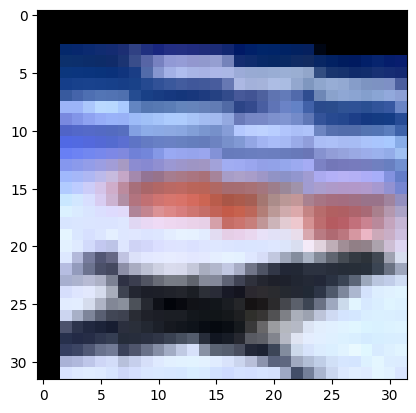

In [ ]:
# Visualizing images from the training set

datatensor = ImageDataset(train_filenames, augmented_transform)
print("Number of images:", len(datatensor))
image, target = datatensor[100] # This will execute the '__getitem__' method
nchannels = image.shape[0]
height    = image.shape[1]
width     = image.shape[2]
image     = image.permute(1,2,0).numpy() # Converts the Tensor back to image shape
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target)
plt.title("Transformed Image")
plt.show()

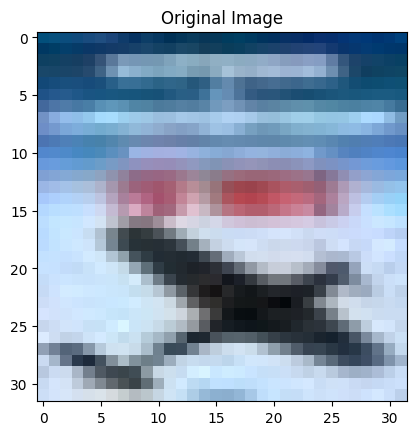

In [ ]:
# Creating an instance of ImageDataset without any transformations
original_dataset = ImageDataset(root_dir=train_filenames, transform=None)

# Accessing the original image (without transformations)
original_image, _ = original_dataset[100]

# Printing the original image
plt.imshow(original_image)
plt.title("Original Image")
plt.show()


## Train a baseline model (1 Point)

Before going for the deep learning approach, you should test a baseline model in this problem. To do so, train a RandomForectClassifier, where the inputs are the flattened images (all pixes of 3 channels concatenated).

You should use the same train/validation/test division that you'll be using in the next section. You can use the Sklearn library for this task. Remember to test and plot a confusion matrix with the results.

In [ ]:
# First Step - Data Preparation:

# Creating instances for training, validation, and test sets without transformations
train_dataset = ImageDataset(root_dir=train_filenames, transform=None)
valid_dataset = ImageDataset(root_dir=validation_filenames, transform=None)
test_dataset = ImageDataset(root_dir=test_filenames, transform=None)

# Loading and flattening images for training, validation, and test sets
X_train = np.array([np.array(image).flatten() for image, _ in train_dataset])
X_valid = np.array([np.array(image).flatten() for image, _ in valid_dataset])
X_test = np.array([np.array(image).flatten() for image, _ in test_dataset])

# Defining labels for training, validation, and test sets
y_train = np.array([label for _, label in train_dataset])
y_valid = np.array([label for _, label in valid_dataset])
y_test = np.array([label for _, label in test_dataset])


In [ ]:
# Second Step - Model Training:

from sklearn.ensemble import RandomForestClassifier

# Initializing the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the RandomForestClassifier(on the training data)
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Validation Accuracy: 0.6600
Validation Precision: 0.6573
Validation Recall: 0.6600
Validation F1-Score: 0.6581


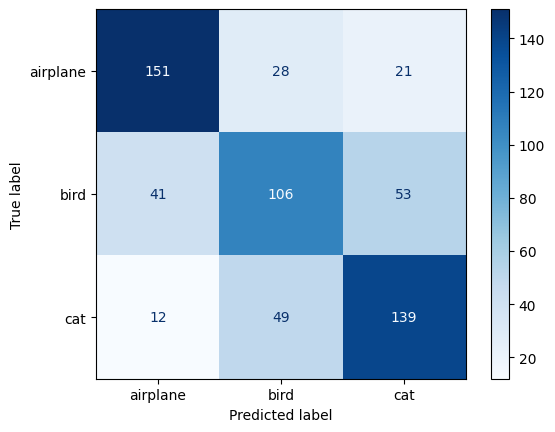

In [ ]:
# Third Step - Model Evaluation:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Predicting on the validation set
y_valid_pred = rf_classifier.predict(X_valid)

# 2. Calculating evaluation metrics
accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred, average='weighted')
recall = recall_score(y_valid, y_valid_pred, average='weighted')
f1 = f1_score(y_valid, y_valid_pred, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-Score: {f1:.4f}')

# 3. Plotting a confusion matrix
conf_matrix = confusion_matrix(y_valid, y_valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['airplane', 'bird', 'cat'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


## Build a CNN (6 Points)

In this section, you should construct and validate a CNN architecture for the given problem.

It's required that you test at least the following parts of a CNN:
- Number of convolutional layers and different output sizes
- Kernel size of filters
- Number of training epochs
- Learning rate of the network
- Batchsize used in dataloader
- Stride on convolutional or pooling layers
- Different architecture for the final dense layer (with or without hidden layers and their size)

Also, you must compare at least for one network if the data augmentation is helping the training process or not.

Lastly, you must change the `Criterion` function to return the balanced accuracy instead of the normal one.

--------

The process to build a CNN is an exploratory analysis and should be done carefully. As this is a costly process, you will not test all possibilities between each other, you should interpret the results at each step and understand what is happening or not happening.

As this is a costly process, you should use the normal division of train/validation/test, instead of cross validation. Also, at each network built and trained/validated, you should look at the results to understand if any overfitting or underfitting is happening. Save the values of each batch of train and validation to analyze how the model performed over the epochs.

### Exploding/vanishing gradients

As we already learned, the weights of a neural network are updated using the backpropagation algorithm. As our network grows in depth, there are two problems that can occur with the backpropagation algorithm, known as Exploding and Vanishing gradients.

As both names imply, both conditions relate to a gradient calculation that goes out of control for some reason.

The exploding gradient can happen when the current weights generate a very large loss, and all the network weights are updated by a huge amount. This can lead to a cycle where the network is not able to learn because every learning step impacts too much the network, making it very unstable.

On the other side, the vanishing gradient will happen when the gradients get too small, and the updates are not able to propagate to the initial layers.

There are a couple of ways to solve those issues. The first is to use an activation function that is "non-saturating". The sigmoid function is an example of a saturating function because its derivative tends to 0 on larger positive or negative values. The best activation functions to avoid this issue are the ReLU and its variations (LReLU, PReLU, ELU, etc). All those examples help to mitigate the vanishing gradient.

Another important step is to initialize the weights of the network properly. Initializing the weights randomly can also lead to vanishing/exploding gradients in some situations. The common strategy is to use a heuristic. We are not going to cover this manner in a deeper aspect, but the Xavier initialization is already implemented in the example below.

Finally, the best thing to avoid vanishing and exploding gradients in a deep CNN is to use the Batch Normalization technique. This technique is a new operation on the CNN, that normalizes its input and adds a parameter for scale and another for shifting. This enables the network to learn the optimal scale and mean of the layer. This normalization uses the data of the batch of images being executed on the model to find the mean and standard deviation. In pytorch, there is a function to use this technique in the `nn` module: `nn.BatchNorm2d()`. The BatchNorm operation can be used before or after the activation function.

For example:
- Conv -> BatchNorm -> Activation(ReLU) -> Pooling
Or
- Conv -> Activation(ReLU) -> BatchNorm -> Pooling).

In this task, you may face problems concerning the stability and convergence of the network because of the exploding or vanishing gradients, and it is recommended that you use the techniques cited to avoid this issue.

In [ ]:
gpu = torch.cuda.is_available()

if not gpu:
  print("GPU not available!")

device = torch.device(0) if gpu else torch.device('cpu')

GPU not available!


**Saving models**

As the CNN training process can take some time, is interesting to save your models, to avoid re-training in the case of a crash or just to save your work for other time.

The next cell shows a simple code to save and load pytorch models. Remember to keep the class of the model in the same way, as the state_dict will not work if you change the architecture. Create new classes for different tests, with names that correctly describe what is being tested.

**Note**: If you're using google colab, just saving the model is not enough. You need to save it for a folder in your google Drive, or download the files after saving them.

In [ ]:
# ===== How to save a pytorch model =====

path = "gdrive/MyDrive/MC886 - Datasets/"


## Since you have the class of the model, you can save the weights
## IMPORTANT: If you change the class implementation you will NOT be able to load the model again.
#torch.save(model.to('cpu').state_dict(), path)

# ===== How to load a pytorch model =====

## Instantiate the model class as usual
#model = Model(input_shape, nclasses)

## Load the state dict saved before
#state_dict  = torch.load(path)

## Load the weights in the model
#model.load_state_dict(state_dict)

## Send the model to the GPU
#model = model.to(device)

**Example of train/validate code**

In the next cells, we show an example of how to develop the train/validation functions using pytorch. You don't need to use this code, but it is a place to start.

In [ ]:
#Creating the dataset
train_dataset = ImageDataset(root_dir=train_filenames, transform=basic_transform, load_into_memory=True)
valid_dataset = ImageDataset(root_dir=validation_filenames, transform=basic_transform, load_into_memory=True)
test_dataset = ImageDataset(root_dir=test_filenames, transform=basic_transform, load_into_memory=True)

In [ ]:
# Custom Criterion function(so we can calculate both loss and accuracy)
def Criterion(model, preds, targets, device):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    pred_labels = torch.max(preds.data, 1)[1]
    acc = torch.sum(pred_labels == targets.data)
    n = pred_labels.size(0)
    acc = acc / n
    return loss, acc

# Training batch function
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims = ims.to(device=device)
    targets = targets.to(device=device)
    preds = model(ims)
    loss, acc = criterion(model, preds, targets, device)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item(), acc.item()

# Validation batch function
@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims = ims.to(device=device)
    targets = targets.to(device=device)
    preds = model(ims)
    loss, acc = criterion(model, preds, targets, device)
    return loss.item(), acc.item()



In [ ]:
class CNN(nn.Module):
    def __init__(self, input_shape, num_classes, conv_layers, conv_out_channels,
                 kernel_size, stride, pool_stride, fc_hidden_units):
        super(CNN, self).__init__()

        #Initializating the layers
        layers = []
        in_channels = input_shape[0]
        # Ensuring conv_out_channels has enough elements
        if len(conv_out_channels) < conv_layers:
            raise ValueError(f"conv_out_channels must have at least {conv_layers} elements")

        #Adding the convolutional layers
        for i in range(conv_layers):
            out_channels = conv_out_channels[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=pool_stride))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        # Computing the size of the flattened features after convolutions
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.conv_layers(x)
            conv_output_size = x.view(1, -1).size(1)

        # Defining the fully connected layers
        if fc_hidden_units is None:
            self.fc_layers = nn.Sequential(
                nn.Linear(conv_output_size, num_classes)
            )
        else:
            self.fc_layers = nn.Sequential(
                nn.Linear(conv_output_size, fc_hidden_units),
                nn.ReLU(),
                nn.Linear(fc_hidden_units, num_classes)
            )

    def forward(self, x):          #Forward pass
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

In [ ]:
data_transforms = {
    'with_augmentation': augmented_transform,
    'without_augmentation': basic_transform
}

In [ ]:
from torchvision.datasets import ImageFolder

# Initializing the network
input_shape = (3, 32, 32)  # Assuming images are 32x32, 3 channels
num_classes = 3            # Number of classes

# Training loop function(only one epoch is executed)
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data[0])}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss:.6f}\tAccuracy: {acc:.6f}')

# Validation loop function(only one epoch is executed)
def validate(model, device, valid_loader, criterion, epoch):
    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(valid_loader):
            loss, acc = validate_batch(model, data, criterion, device)
            valid_loss += loss
            valid_acc += acc
            if batch_idx % 100 == 0:
                print(f'Validation: [{batch_idx * len(data[0])}/{len(valid_loader.dataset)}'
                      f' ({100. * batch_idx / len(valid_loader):.0f}%)]\tLoss: {loss:.6f}\tAccuracy: {acc:.6f}')
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)
    print(f'\nValidation set: Average loss: {valid_loss:.4f}, Accuracy: {valid_acc:.4f}\n')


In [ ]:
# Training and validation function(over multiple epochs)
def train_and_validate(model, device, train_loader, valid_loader, optimizer, criterion, num_epochs):
    train_loss_history, train_acc_history = [], []
    valid_loss_history, valid_acc_history = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)

        model.eval()
        valid_loss, valid_correct = 0.0, 0
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                valid_correct += (predicted == labels).sum().item()

        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = valid_correct / len(valid_loader.dataset)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

    results = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'valid_loss': valid_loss_history,
        'valid_acc': valid_acc_history
    }

    return results


In [ ]:
batch_size = 64
# DataLoaders with configurable batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from itertools import product


  # Function to plot progress
def plot_progress(results, ax, title):
    epochs = range(1, len(results['train_loss']) + 1)
    train_loss = results['train_loss']
    train_acc = results['train_acc']
    valid_loss = results['valid_loss']
    valid_acc = results['valid_acc']

    ax[0].plot(epochs, train_loss, label='Train Loss')
    ax[0].plot(epochs, valid_loss, label='Valid Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title(title + ' - Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc, label='Train Acc')
    ax[1].plot(epochs, valid_acc, label='Valid Acc')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title(title + ' - Accuracy')
    ax[1].legend()

# Defining the hyperparameter range
num_epochs_options = [15, 40]
learning_rate_options = [0.01] #, 0.001]
batch_size_options = [32, 64]
conv_layers_options = [2]#, 3]
conv_out_channels_options = [[32, 64]]#, [32, 64, 128]]
kernel_size_options = [3, 5]
stride_options = [1] #, 2]
pool_stride_options = [2]
fc_hidden_units_options = [None, 128]

# Generating valid combinations of conv_layers and conv_out_channels
valid_conv_combinations = []
for conv_layers, conv_out_channels in product(conv_layers_options, conv_out_channels_options):
    if len(conv_out_channels) == conv_layers:
        valid_conv_combinations.append((conv_layers, conv_out_channels))

hyperparameter_combinations = list(product(num_epochs_options, learning_rate_options, batch_size_options,
                                           valid_conv_combinations, kernel_size_options,
                                           stride_options, pool_stride_options, fc_hidden_units_options))

# Main function to iterate over hyperparameters and transformations
def main():
    all_results = {'with_augmentation': [], 'without_augmentation': []}

    for transform_type, transform in data_transforms.items():
        print(f"Running with {transform_type} transformations")

        train_dataset = ImageDataset(root_dir=train_filenames, transform=transform, load_into_memory=True)
        valid_dataset = ImageDataset(root_dir=validation_filenames, transform=transform, load_into_memory=True)
        input_shape = (3, 32, 32)  # Adjust according to the dataset
        num_classes = 3

        for hp_combination in hyperparameter_combinations:
            num_epochs, learning_rate, batch_size, (conv_layers, conv_out_channels), kernel_size, stride, pool_stride, fc_hidden_units = hp_combination

            if stride == 2 and 2 == pool_stride and conv_layers == 3:
                continue  # Skip this combination since stride cannot be greater than pool_stride

            print(f'Training with hyperparameters: epochs={num_epochs}, lr={learning_rate}, batch_size={batch_size}, conv_layers={conv_layers}, conv_out_channels={conv_out_channels}, kernel_size={kernel_size}, stride={stride}, pool_stride={pool_stride}, fc_hidden_units={fc_hidden_units}')

            # Creating DataLoader
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

            # Initializing the network with the current hyperparameters
            model = CNN(input_shape, num_classes, conv_layers, conv_out_channels, kernel_size, stride, pool_stride, fc_hidden_units).to(device)
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()

            # Train and validate the model
            results = train_and_validate(model, device, train_loader, valid_loader, optimizer, criterion, num_epochs)
            all_results[transform_type].append((hp_combination, results, model))

    # Find the top 4 models for each type of transformation
    sorted_results_with_aug = sorted(all_results['with_augmentation'], key=lambda x: x[1]['valid_acc'][-1], reverse=True)[:4]
    sorted_results_without_aug = sorted(all_results['without_augmentation'], key=lambda x: x[1]['valid_acc'][-1], reverse=True)[:4]

    # Create a figure for the best models
    #fig, axs = plt.subplots(4, 2, figsize=(20, 20))

    #fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    #axs = axs.ravel()
    return sorted_results_with_aug, sorted_results_without_aug

# Runs the main function:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models_augmented, models_basic = main()

Running with with_augmentation transformations
Training with hyperparameters: epochs=15, lr=0.01, batch_size=32, conv_layers=2, conv_out_channels=[32, 64], kernel_size=3, stride=1, pool_stride=2, fc_hidden_units=None
Epoch 1/15 - Train Loss: 3.4043, Train Accuracy: 0.4358 - Valid Loss: 2.9551, Valid Accuracy: 0.3400
Epoch 2/15 - Train Loss: 1.7720, Train Accuracy: 0.5242 - Valid Loss: 2.9394, Valid Accuracy: 0.5367
Epoch 3/15 - Train Loss: 1.5471, Train Accuracy: 0.5417 - Valid Loss: 1.7520, Valid Accuracy: 0.5333
Epoch 4/15 - Train Loss: 1.4106, Train Accuracy: 0.5575 - Valid Loss: 1.1300, Valid Accuracy: 0.6183
Epoch 5/15 - Train Loss: 1.0640, Train Accuracy: 0.6117 - Valid Loss: 2.2999, Valid Accuracy: 0.3850
Epoch 6/15 - Train Loss: 0.9472, Train Accuracy: 0.6500 - Valid Loss: 1.7420, Valid Accuracy: 0.5417
Epoch 7/15 - Train Loss: 1.0285, Train Accuracy: 0.6392 - Valid Loss: 1.0179, Valid Accuracy: 0.5700
Epoch 8/15 - Train Loss: 0.8474, Train Accuracy: 0.6817 - Valid Loss: 0.9529

Model saved to model_epoch40_lr0.01_batch32_conv2_out[32, 64]_kernel3_stride1_pool2_fc128.pth
Model saved to model_epoch15_lr0.01_batch64_conv2_out[32, 64]_kernel3_stride1_pool2_fc128.pth
Model saved to model_epoch40_lr0.01_batch64_conv2_out[32, 64]_kernel5_stride1_pool2_fcNone.pth
Model saved to model_epoch40_lr0.01_batch32_conv2_out[32, 64]_kernel3_stride1_pool2_fcNone.pth


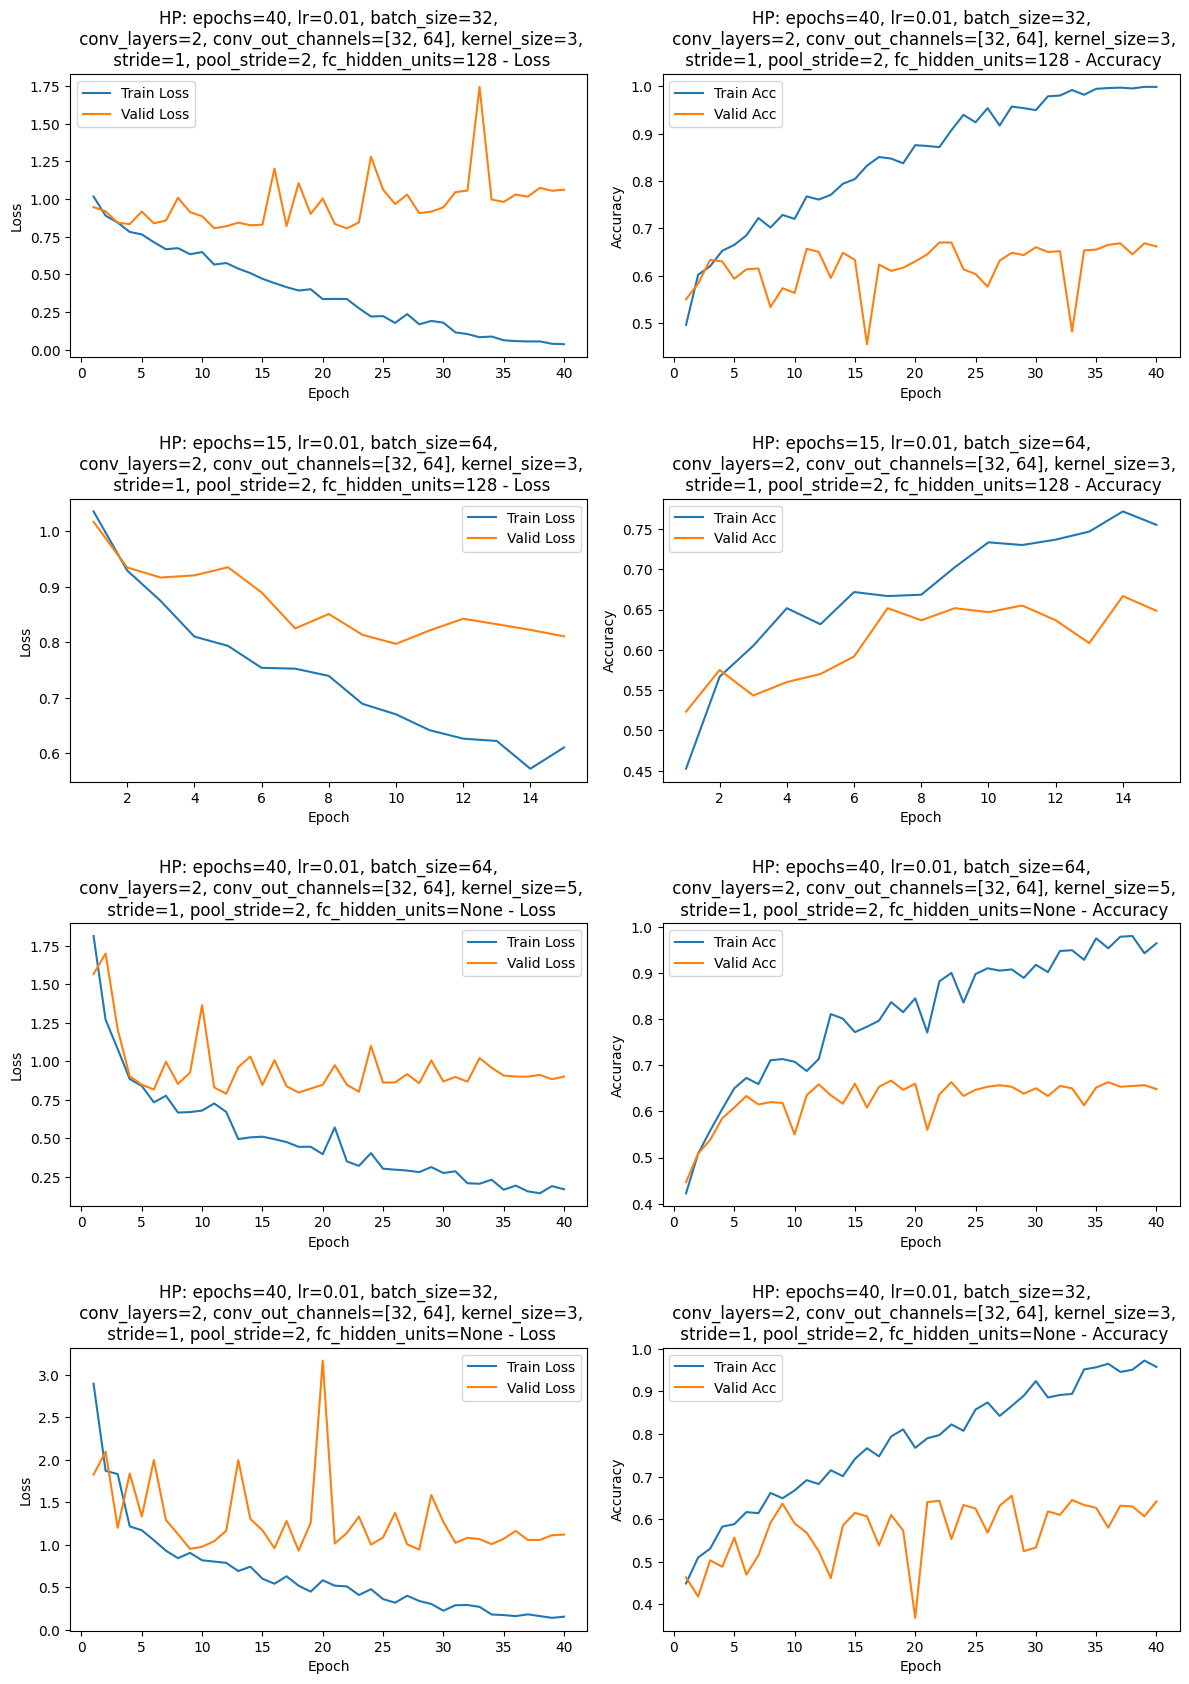

In [ ]:
model_basic = []
model_augmented = []


fig, axs = plt.subplots(4, 2, figsize=(12, 17))

# Iterating over augmented models and plot results:
for i, (hp_combination, results, model) in enumerate(models_augmented):
    title = (f'HP: epochs={hp_combination[0]}, lr={hp_combination[1]}, batch_size={hp_combination[2]},\n '
              f'conv_layers={hp_combination[3][0]}, conv_out_channels={hp_combination[3][1]}, kernel_size={hp_combination[4]},\n '
              f'stride={hp_combination[5]}, pool_stride={hp_combination[6]}, fc_hidden_units={hp_combination[7]}')
    plot_progress(results, axs[i], title)

    # Saving the models
    model_path = f'model_epoch{hp_combination[0]}_lr{hp_combination[1]}_batch{hp_combination[2]}_conv{hp_combination[3][0]}_out{hp_combination[3][1]}_kernel{hp_combination[4]}_stride{hp_combination[5]}_pool{hp_combination[6]}_fc{hp_combination[7]}.pth'
    torch.save(model.to('cpu').state_dict(), model_path)
    print(f'Model saved to {model_path}')

    model_augmented.append(model)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.5)
plt.show()

Model saved to model_epoch15_lr0.01_batch64_conv2_out[32, 64]_kernel3_stride1_pool2_fc128.pth
Model saved to model_epoch15_lr0.01_batch32_conv2_out[32, 64]_kernel3_stride1_pool2_fc128.pth
Model saved to model_epoch15_lr0.01_batch64_conv2_out[32, 64]_kernel3_stride1_pool2_fcNone.pth
Model saved to model_epoch40_lr0.01_batch64_conv2_out[32, 64]_kernel3_stride1_pool2_fc128.pth


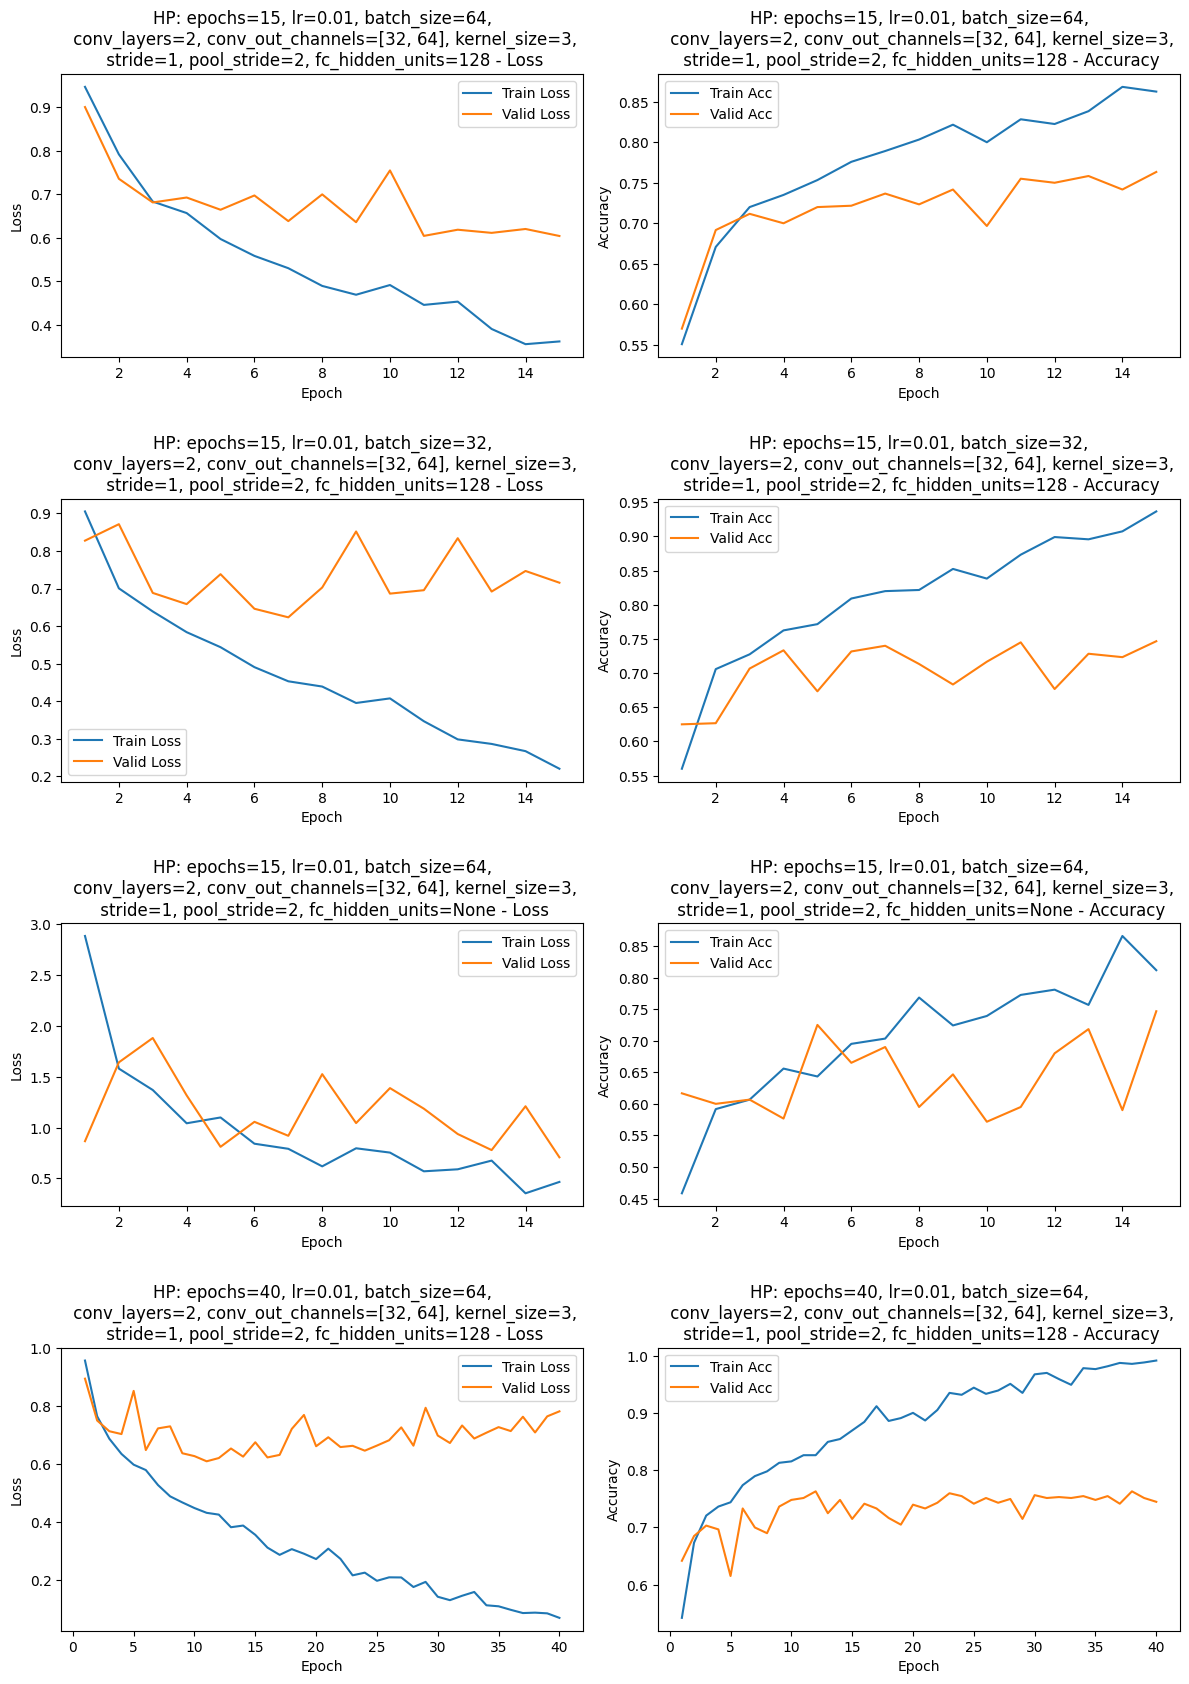

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 17))

for i, (hp_combination, results, model) in enumerate(models_basic):
    title = (f'HP: epochs={hp_combination[0]}, lr={hp_combination[1]}, batch_size={hp_combination[2]},\n '
              f'conv_layers={hp_combination[3][0]}, conv_out_channels={hp_combination[3][1]}, kernel_size={hp_combination[4]},\n '
              f'stride={hp_combination[5]}, pool_stride={hp_combination[6]}, fc_hidden_units={hp_combination[7]}')
    plot_progress(results, axs[i], title)

    # Saving the models
    model_path = f'model_epoch{hp_combination[0]}_lr{hp_combination[1]}_batch{hp_combination[2]}_conv{hp_combination[3][0]}_out{hp_combination[3][1]}_kernel{hp_combination[4]}_stride{hp_combination[5]}_pool{hp_combination[6]}_fc{hp_combination[7]}.pth'
    torch.save(model.to('cpu').state_dict(), model_path)
    print(f'Model saved to {model_path}')

    model_augmented.append(model)

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.5)
plt.show()

In [ ]:
# Evaluating each trained model on the test dataset
for i, (hp_combination, results, model) in enumerate(models_basic):
    title = f'Model {i+1} Without Augmentation'
    print(f'Evaluating {title}:')
    evaluate_model(model, test_loader)


Evaluating Model 1 Without Augmentation:
Accuracy on the test set: 0.7133
Evaluating Model 2 Without Augmentation:
Accuracy on the test set: 0.7256
Evaluating Model 3 Without Augmentation:
Accuracy on the test set: 0.7144
Evaluating Model 4 Without Augmentation:
Accuracy on the test set: 0.7333


### Early stopping regularization (EXTRA: 1 Point)

This can only be done if you are able to find a CNN that was able to overfit the train dataset.

If that is the case, change the training function in order to perform an [early stopping](https://en.wikipedia.org/wiki/Early_stopping). The early stopping technique using validation is a technique to stop the training process when a defined condition is achieved. Find this condition and change the code.

Discuss the results and why they happened (it works? Why?)


Training Model 1 Without Augmentation
Epoch 1/15 - Train Loss: 0.0286, Train Accuracy: 0.9992 - Valid Loss: 0.8249, Valid Accuracy: 0.7517
Epoch 2/15 - Train Loss: 0.0311, Train Accuracy: 1.0000 - Valid Loss: 0.7956, Valid Accuracy: 0.7667
Epoch 3/15 - Train Loss: 0.0264, Train Accuracy: 1.0000 - Valid Loss: 0.7954, Valid Accuracy: 0.7633
Epoch 4/15 - Train Loss: 0.0266, Train Accuracy: 0.9992 - Valid Loss: 0.8029, Valid Accuracy: 0.7617
Epoch 5/15 - Train Loss: 0.0272, Train Accuracy: 1.0000 - Valid Loss: 0.8212, Valid Accuracy: 0.7617
Epoch 6/15 - Train Loss: 0.0234, Train Accuracy: 0.9992 - Valid Loss: 0.8267, Valid Accuracy: 0.7650
Epoch 7/15 - Train Loss: 0.0220, Train Accuracy: 1.0000 - Valid Loss: 0.8206, Valid Accuracy: 0.7650
Early stopping triggered
Trained model saved to trained_model_without_augmentation_0.pth
Training Model 2 Without Augmentation
Epoch 1/15 - Train Loss: 0.0090, Train Accuracy: 1.0000 - Valid Loss: 1.0049, Valid Accuracy: 0.7667
Epoch 2/15 - Train Loss: 0.

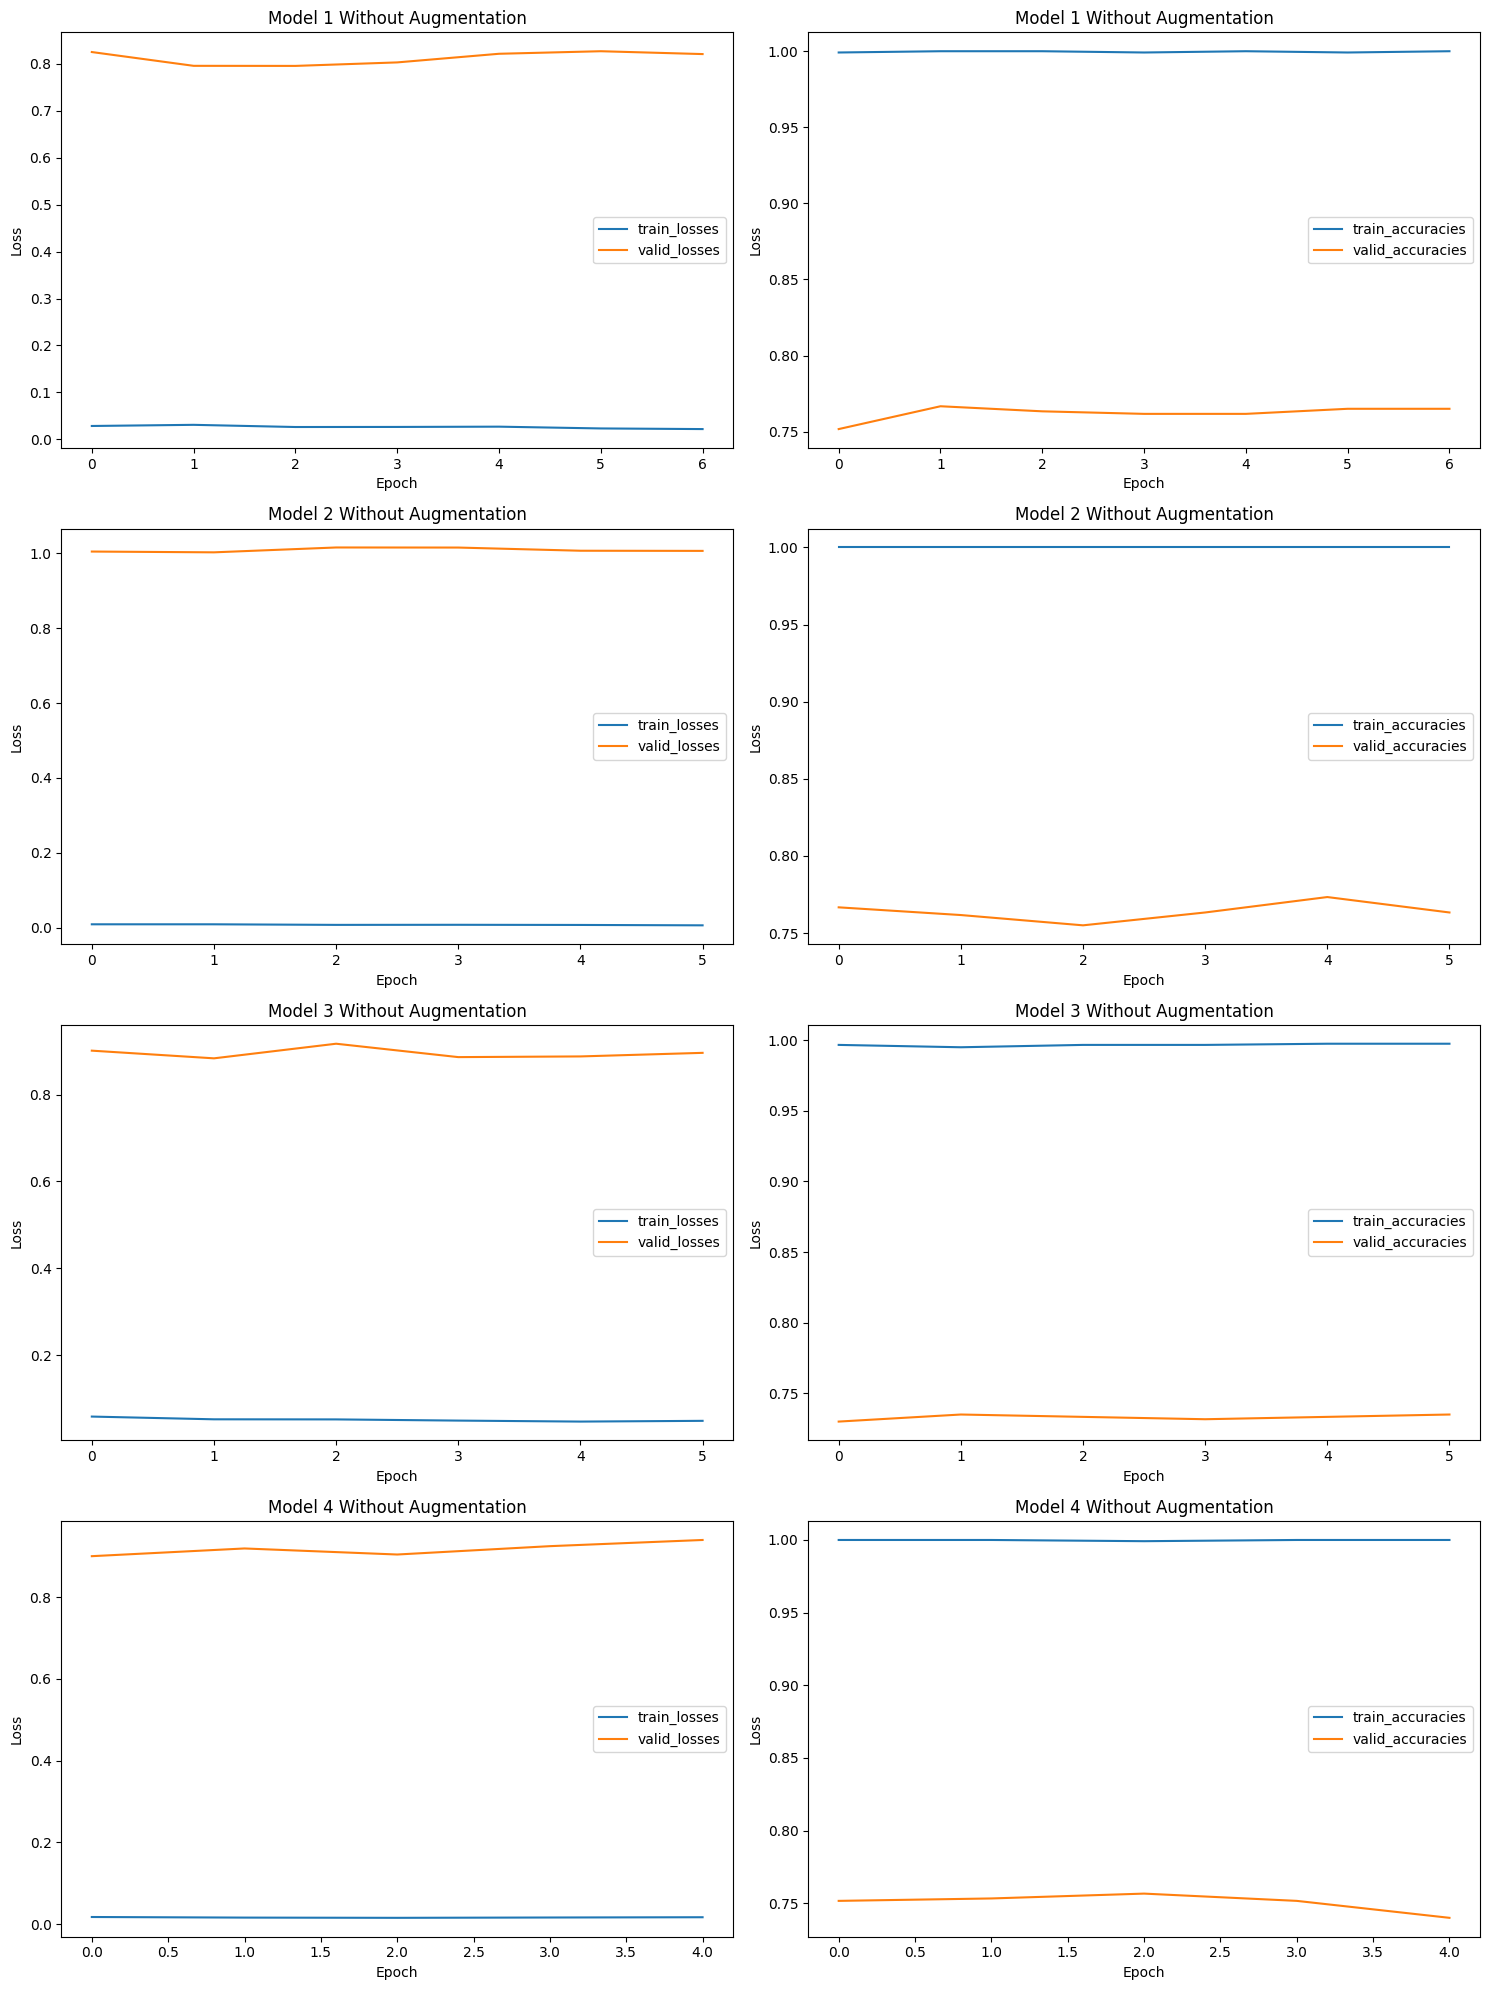

In [ ]:

# Creating dataloaders with and without data augmentation
def create_dataloaders(transform, batch_size):
    train_dataset = ImageDataset(root_dir=train_filenames, transform=transform, load_into_memory=True)
    valid_dataset = ImageDataset(root_dir=validation_filenames, transform=transform, load_into_memory=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Defining the training function with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_val_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        valid_losses.append(epoch_val_loss)
        valid_accuracies.append(epoch_val_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f} - Valid Loss: {epoch_val_loss:.4f}, Valid Accuracy: {epoch_val_acc:.4f}')

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping triggered')
                break

    # Loading the best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

# Function to plot the progress
def plot_progress2(results, ax, title, X, Y):
    ax.plot(results[X], label=X)
    ax.plot(results[Y], label=Y)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

# Main function to train the models with early stopping
def main(models_basic):
    # Plot configuration
    fig, axs = plt.subplots(len(models_basic), 2, figsize=(15, len(models_basic) * 5))
    axs = axs.ravel()

    # Training and plotting models without data augmentation
    for i, (hp_combination, results, model) in enumerate(models_basic):
        title = f'Model {i+1} Without Augmentation'
        print(f'Training {title}')

        # Getting the model's hyperparameters
        epochs, lr, batch_size, (conv_layers, conv_out_channels), kernel_size, stride, pool_stride, fc_hidden_units = hp_combination

        # Creating dataloaders without data augmentation
        train_loader, val_loader = create_dataloaders(basic_transform, batch_size)

        # Initializing criterion and optimizer
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)

        # Training the model with early stopping
        model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model_with_early_stopping(
            model, train_loader, val_loader, criterion, optimizer, num_epochs=epochs, patience=4
        )

        # Plotting training and validation losses
        results = {'train_losses': train_losses, 'valid_losses': valid_losses}
        plot_progress2(results, axs[i*2], title, 'train_losses', 'valid_losses')

        results = {'train_accuracies': train_accuracies, 'valid_accuracies': valid_accuracies}
        plot_progress2(results, axs[i*2+1], title, 'train_accuracies', 'valid_accuracies')

        # Saving the trained model
        model_path = f'trained_model_without_augmentation_{i}.pth'
        torch.save(model.to('cpu').state_dict(), model_path)
        print(f'Trained model saved to {model_path}')

    plt.tight_layout()
    plt.show()


main(models_basic)


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / len(test_loader.dataset)
    print(f'Accuracy on the test set: {accuracy:.4f}')

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluating each trained model on the test dataset
for i, (hp_combination, results, model) in enumerate(models_basic):
    title = f'Model {i+1} Without Augmentation'
    print(f'Evaluating {title} on the test dataset:')
    evaluate_model(model, test_loader)


Evaluating Model 1 Without Augmentation on the test dataset:
Accuracy on the test set: 0.7122
Evaluating Model 2 Without Augmentation on the test dataset:
Accuracy on the test set: 0.7200
Evaluating Model 3 Without Augmentation on the test dataset:
Accuracy on the test set: 0.7211
Evaluating Model 4 Without Augmentation on the test dataset:
Accuracy on the test set: 0.7167


Above, we have defined that the early stopping condition is based on the validation loss: the model stops if the validation loss stops decreasing or if it starts increasing for a specified number of consecutive epochs, where this number is defined by the "patience" parameter.

We can start our discussion by the easily noticeable change in the models robustness when early stopping is applied. All the original models, the ones without early stopping, are way more sensitive to variations in the hyperparameters or in the dataset, since both losses and accuracies varies considerably between epochs.

Another clear difference resides in the training time. Once early stopping interrupts the training process as the validation performance gets worse, way less epochs are trained and the models are way more computationally efficient in matter of time spent in the training process.

Now, we can compare the models capacity, with and without early stopping, at generalizating to new data. For the original models, we've got:


1.   Original Models:

* Test set accuracy for Model 1: 0.7133

* Test set accuracy for Model 2: 0.7256

* Test set accuracy for Model 3: 0.7144

* Test set accuracy for Model 4: 0.7333


2.   Early stopping Models:


* Test set accuracy for Model 1: 0.7122

* Test set accuracy for Model 2: 0.7200

* Test set accuracy for Model 3: 0.7211

* Test set accuracy for Model 4: 0.7167


Taking in consideration that the early stopping technique should prevent overfitting, we can notice that the early stopping applied above isn´t as effective as it should be, once the accuracy on test sets decreases, in their majority, in comparison to the original models. Usually, models with early stopping should have better generalization to new and unseen data.
This result depends of several factors, like data quality, model complexity, hyperparameters used and randomness.

## Interpertability on CNNs (1 point)

The Gradient-weighted Class Activation Mapping (Grad-CAM) technique uses the gradient of one or more convolutional layers to highlight the regions of the image that were more impactful to a prediction. For more details, you can read [this paper](https://arxiv.org/abs/1610.02391).

The idea is to use the gradient to create a heatmap indicating the parts that had more weight on the decision for a given sample.

In the next cells, the Grad-CAM code is defined for one layer. You should use this code to test a few images of your best CNN defined in the previous sections. You can change the visualizations if you want.

Analyze the results of Grad-CAM for different images and classes, and discuss whether the model is focusing or not on the right parts of the image and why this may be happening. Feel free to change the code below to visualize in a different way (different quantity of images, different labeling, etc).

-------

**Important: The code below has some assumptions about the network architecture. If the model class is built in a different way you MUST change the implementation of the `get_activations` function.**

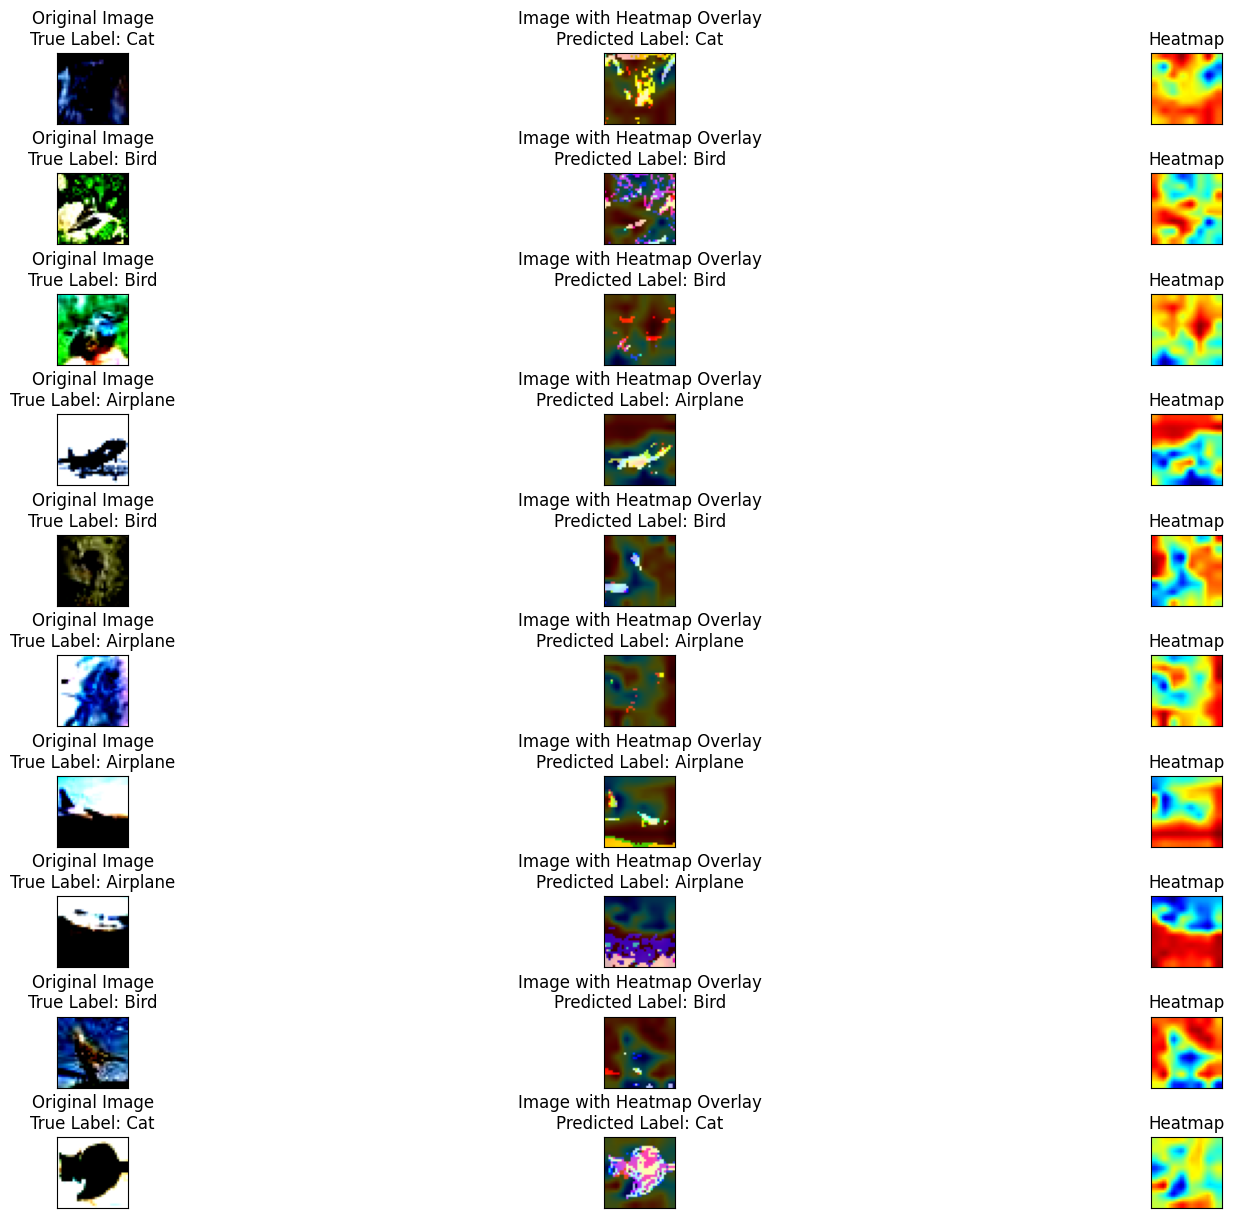

In [ ]:
import random

# Main code
model = models_basic[0][-1]

fig, axes = plt.subplots(10, 3, figsize=(20, 15), subplot_kw={'xticks': [], 'yticks': []})

test_dataset = ImageDataset(root_dir=test_filenames, transform=basic_transform, load_into_memory=True)

for i, ax_row in enumerate(axes):
    image, true_label = test_dataset[random.randint(0, len(test_dataset))]
    image = image.unsqueeze(0).to(device)  # Adds batch dimension and move to device

    # Changes access to the last convolutional layer
    target_layer = [layer for layer in model.conv_layers if isinstance(layer, torch.nn.Conv2d)][-1]

    # Generates heatmap and predicted label
    heatmap, predicted_label = get_heatmap(model, image, target_layer, device)
    image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Adjusts dimensions for visualization

    # Overlays heatmap on original image
    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlaid_img = cv2.addWeighted(image_np.astype(np.uint8), 0.7, heatmap, 0.3, 0)

    # Displays side-by-side comparison
    ax_row[0].imshow(image_np)
    ax_row[0].set_title(f"Original Image\nTrue Label: {labels_map[true_label]}")

    ax_row[1].imshow(overlaid_img)
    ax_row[1].set_title(f"Image with Heatmap Overlay\nPredicted Label: {predicted_label}")

    ax_row[2].imshow(heatmap)
    ax_row[2].set_title("Heatmap")

plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()


For the analysis requested, we have coded, above, multiple ways to visualize the images. On the left, we plotted the original image(without transformations); in the middle, we plotted the same image but with a overlayed heatmap; on the right, we plotted exclusively their respective heatmap.

As we can see, the model has a pretty decent capacity of correctfully predicting the images classes. However, by observing their heatmaps, we can see that the model often focuses on areas that aren´t vital to the classification of the image. This may happen for several reasons, like: overfitting, model architecture, imbalanced classes, limited training data, noise data, etc.

However, as discussed earlier, the main reason probably is overfitting, as we noticed in the comparison between the models with and without early stopping.
This problem can likely be solved with the application of regularization techniques or with a better stopping parameter.

## Deadline

Saturday, June 01, 11:59 pm.

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- June 02, 11:59 pm : grade * 0.75
- June 03, 11:59 pm : grade * 0.5
- June 04, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English) or Google Colaboratory link (remember to share it!).

**This activity is NOT individual, it must be done in pairs (two-person group).**

Only one individual should deliver the notebook.